In [1]:
# from pm4py.objects.log.importer.xes import importer as xes_importer
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import datetime
import random
import time
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import preprocessing as pre
from sklearn import tree
import matplotlib.pyplot as plt
from collections import Counter
import math
import tracemalloc
import psutil

### Since the data is already converted, I markdowned the cell below. 

### This is how did we convert the .xes into .csv

#XES TO CSV
xesToCsv_BPI = xes_importer.apply("Datasets/BPI_Challenge_2012.xes")

xesToCsv_listo = []
xesToCsv_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):

    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_attr_list = list(xesToCsv_BPI[i][j])
    
        for k in range(0, len(xesToCsv_attr_list)):
            xesToCsv_prev_attr = xesToCsv_cur_attr
            xesToCsv_cur_attr = xesToCsv_attr_list[k]

            if xesToCsv_cur_attr not in xesToCsv_listo:
                xesToCsv_value = xesToCsv_dic[xesToCsv_prev_attr] + 1
            
                for key in xesToCsv_dic:
                    if xesToCsv_dic[key] >= xesToCsv_value:
                        xesToCsv_dic[key] += 1
            
                xesToCsv_dic[xesToCsv_cur_attr] = xesToCsv_value
                xesToCsv_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
        
        xesToCsv_cur_attr = 'no'
        
        
xesToCsv_chain = []
xesToCsv_event = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_chain.append(i)
        xesToCsv_event.append(j)
        
xesToCsv_df_BPI= pd.DataFrame(index=[np.array(xesToCsv_chain), np.array(xesToCsv_event)], columns = xesToCsv_listo)

for i in tqdm(range(0, len(xesToCsv_BPI))):
    
    for j in range(0, len(xesToCsv_BPI[i])):

        xesToCsv_attr = xesToCsv_BPI[i][j]
        
        for a in xesToCsv_attr:
            xesToCsv_df_BPI.loc[(i, j), a] = xesToCsv_attr[a]
            
            
xesToCsv_df_BPI.to_csv('Datasets/BPI_2012.csv')

xesToCsv_attr_listo = []
xesToCsv_attr_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_list = list(xesToCsv_BPI[i].attributes)
    
    for k in range(0, len(xesToCsv_attr_list)):
        xesToCsv_prev_attr = xesToCsv_cur_attr
        xesToCsv_cur_attr = xesToCsv_attr_list[k]

        if xesToCsv_cur_attr not in xesToCsv_attr_listo:
            xesToCsv_value = xesToCsv_attr_dic[xesToCsv_prev_attr] + 1
            
            for key in xesToCsv_attr_dic:
                if xesToCsv_attr_dic[key] >= xesToCsv_value:
                    xesToCsv_attr_dic[key] += 1
            
            xesToCsv_attr_dic[xesToCsv_cur_attr] = xesToCsv_value
            xesToCsv_attr_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
    
    xesToCsv_cur_attr = 'no'
    
    
xesToCsv_attr_chain = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_chain.append(i)
    

xesToCsv_df_BPI_attr = pd.DataFrame(index = [np.array(xesToCsv_attr_chain)], columns = xesToCsv_attr_listo)


for i in tqdm(range(0, len(xesToCsv_BPI))):

    xesToCsv_attr = xesToCsv_BPI[i].attributes
    
    for a in xesToCsv_attr:
        xesToCsv_df_BPI_attr.loc[i, a] = xesToCsv_attr[a]
        
xesToCsv_df_BPI_attr.to_csv('Datasets/BPI_attr_2012.csv')

if 'Unnamed: 0' in xesToCsv_df_BPI.columns:
    xesToCsv_df_BPI = xesToCsv_df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    xesToCsv_df_BPI_attr = xesToCsv_df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})

## Data loading:

Loads the data with some safety-features for common mishaps we had

In [2]:
def fix_time(time):
    return (datetime.datetime.fromisoformat(time))

def load_data(BPI = 'BPI.csv', BPI_attr = 'BPI_attr.csv',  data2012 = False, sample=False):
    df_BPI = pd.read_csv(BPI)
    df_BPI_attr = pd.read_csv(BPI_attr)
    
    if 'Unnamed: 0' in df_BPI.columns:
        df_BPI = df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
        df_BPI_attr = df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    df_BPI['time:timestamp'] = df_BPI['time:timestamp'].apply(fix_time)

    df_BPI_attr['REG_DATE'] = df_BPI_attr['REG_DATE'].apply(fix_time)
    
    df_BPI['time:weekday'] = [x.weekday() for x in df_BPI['time:timestamp']]
    df_BPI['time:hour'] = [x.hour for x in df_BPI['time:timestamp']]
    df_BPI['time:day'] = [str(x.day) + '-' + str(x.month) + '-' + str(x.year) for x in df_BPI['time:timestamp']]
    df_BPI['time:event_count'] = df_BPI.groupby('time:day')['time:day'].transform('count')
    df_BPI['time:busy_day'] = df_BPI['time:event_count'] > 2525
    
    if(sample):
        df_BPI, df_BPI_attr = df_BPI[:50000], df_BPI_attr[:2359]
    
    return (df_BPI, df_BPI_attr)

def load_data_xes(data):
    BPI = xes_importer.apply(data)

In [3]:
#Warning: if sample=True, please bear it in mind. If you have any loops iterating over the entire df, don't rig them
df, df_attr = load_data(BPI = 'Datasets/BPI_2012.csv', BPI_attr = 'Datasets/BPI_attr_2012.csv', sample=False)

## Data splitting:

The bellow code splits the data and saves it. This code takes around 9 minutes to run. Thus we have added the pre-split data to the zip file, which can be loaded in the next part.

In [4]:
def data_split(df : pd.DataFrame, amount_train_data = 0.8, valitest_size = 0.2) -> tuple:
    '''Plug in the df and train and validation data percentages
    
    the amount of train data splits the data in test and train/validation data
    The valitest_size determines how much of the train/validation set in validation'''
    
    amount_validation_data = 1 - amount_train_data
    
    #Renaming the column names if neccesary and creating a copy of the input df:
    splitData_df = df.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    splitData_df_attr = df_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    #get the limit date
    last_case_id = list(splitData_df['case_id'])[-1]
    splitData_limit_date = splitData_df[splitData_df['case_id'] == round(last_case_id * amount_train_data)]
    splitData_limit_date = list(splitData_limit_date['time:timestamp'])[0]

    #divide the dateset into before and after the limit date
    before_limit_date = splitData_df[splitData_df['time:timestamp'] < splitData_limit_date]
    after_limit_date = splitData_df[splitData_df['time:timestamp'] >= splitData_limit_date]
    
    #get the test datasets
    test_data_cases = list(after_limit_date[after_limit_date['step_number'] == 0]['case_id'])
    df_test = splitData_df[splitData_df['case_id'].isin(test_data_cases)]

    #get the cases for the train and validation data set
    final_step_before_limit_date = pd.Series(before_limit_date.step_number.values,index=before_limit_date.case_id).to_dict()
    final_steps = pd.Series(splitData_df.step_number.values,index=splitData_df.case_id).to_dict()
    train_data_cases = [k for k in final_step_before_limit_date if k in final_steps and final_steps[k] == final_step_before_limit_date[k]]

    #randomly divide up the train/validaiton data sets
    mask = len(train_data_cases) * valitest_size
    random.shuffle(train_data_cases)
    df_validation = splitData_df[splitData_df['case_id'].isin(train_data_cases[:int(mask)])]
    df_train = splitData_df[splitData_df['case_id'].isin(train_data_cases[int(mask):])]
    
    #Re-setting the index:
    df_train, df_validation, df_test = df_train.reset_index(drop=True), df_validation.reset_index(drop=True), df_test.reset_index(drop=True)
    
    return(df_train, df_validation, df_test)

Using the sample data for this split:

In [5]:
df_train, df_validation, df_test = data_split(df, 0.835, 0.525)

In [6]:
df_train.to_csv('Datasets/trainExample.csv')
df_validation.to_csv('Datasets/validationExample.csv')
df_test.to_csv('Datasets/testExample.csv')

## Load the training, validation and test data:

In [7]:
df_train, df_validation, df_test = pd.read_csv('Datasets/trainExample.csv'), pd.read_csv('Datasets/validationExample.csv'), pd.read_csv('Datasets/testExample.csv')
#df_train['time:timestamp'], df_validation['time:timestamp'], df_test['time:timestamp'] = df_train['time:timestamp'].apply(fix_time), df_validation['time:timestamp'].apply(fix_time), df_test['time:timestamp'].apply(fix_time)

## Baseline:

### Pre-processing part:

In [8]:
def changing_columns_names(df : pd.DataFrame, data2012=True, data2017=False):
    '''so far only works with the 2012 dataframe'''
    print(df.columns)
    if(len(df.columns) == 8):
        df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
                      'concept:name', 'time:timestamp', 'time:weekday', 'time:hour']
    
    elif (len(df.columns) == 11):
        df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
                      'concept:name', 'time:timestamp', 'time:weekday', 'time:hour', 'time:time_between',
                     'time:day', 'time:event_count', 'time:busy_day']
    else:
        df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
                      'concept:name', 'time:timestamp', 'time:weekday', 'time:hour', 'time:time_between']
#     elif(data2017):
#         df.columns = ['case_id', 'step_number', 'OfferID', 'Action', 'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 
#                       'org:resource', 'concept:name', 'MonthlyCost', 'EventOrigin', 'EventID', 'Selected', 'CreditScore', 
#                       'lifecycle:transition', 'OfferedAmount', 'time:timestamp', 'time:weekday', 'time:hour']
    
    return(df)

#Erasing all the non-complete actions from the database:
def erasing_noncomplete(df : pd.DataFrame):
    '''Performance depends on the type of the input dataframe
    
    Not so wise!
    
    Event class: conceptname+lifecycletransition'''
    
    df = df[df['lifecycle:transition'] == 'COMPLETE']
    df = df.reset_index(drop=True)
        
    return(df)

def compute_time_difference(df : pd.DataFrame):
    '''Set the time difference column
    This function is places here because of the erased non-complete actions
    
    It has been a no-input, no-return function, so I fixed this ~ Rav'''
    df['time:time_between'] = df['time:timestamp'].diff()
    df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
    #df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
    df.loc[0, 'time:time_between'] = pd.Timedelta(0)
    
    #This one is required for cluster-tree but crashes the baseline, fml:
#     df["time:time_between"] = [int(x.total_seconds()) for x in df["time:time_between"]]
    
    return(df)

def preprocessing(df):
    '''runs the above 3 functions'''
    
    # df = changing_columns_names(df)
    # df = erasing_noncomplete(df)
    df = compute_time_difference(df)
    
    return(df)

## Baseline

### The algorithm's functions (only run 'baseline', it has the other ones embedded)

In [9]:
def creating_dict_for_next_step_stats (df : pd.DataFrame, concept_name : str) -> dict:
    '''For an input action checks for all the possible next actions and counts their occurence'''
    
    dic_occurrence = {}
    dic_total_time = {}
    ids = list(df['case_id']) + ['editor: last id'] #Otherwise we check i+1-th position that does not exist
    times = list(df['time:time_between']) + [pd.Timedelta(0)] #Otherwise we check i+1-th position that does not exist
    names = df['concept:name']
    df_concept = df[names == concept_name]
    
    for i, row in df_concept.iterrows():
        
        if (ids[i] == ids[i+1]): #an instance of the same case
            
            if (names[i+1] not in dic_occurrence):
                dic_occurrence[names[i+1]] = 1
                dic_total_time[names[i+1]] = times[i+1]
            else:
                dic_occurrence[names[i+1]] += 1
                dic_total_time[names[i+1]] += times[i+1]
                
        else: #the last instance of the case
            
            if ('editor: close_case' not in dic_occurrence):
                dic_occurrence['editor: close_case'] = 1
                dic_total_time['editor: close_case'] = times[i+1]
            else:
                dic_occurrence['editor: close_case'] += 1
                dic_total_time['editor: close_case'] += times[i+1]
    
    #Compute average time
    dic_avg_time = {}
    
    for key in dic_total_time:
        dic_avg_time[key] = dic_total_time[key] / dic_occurrence[key]
        
    return(dic_occurrence, dic_avg_time)

def choosing_next_action(dic : dict):
    '''Finds the max value of the input dict and returns the key of the max value'''
    
    max_key = max(dic, key=dic.get)
    return(max_key)


def cycles_shortcut(actions : list, concept_name : str, max_length : int, printing = False) -> list or bool:
    '''For saving the operating time, we will try to terminate the baseline early if we get into a loop
    max_length is the longest_trace parameter'''
    
    if(concept_name in actions): #the action has already been done
        
        if(actions[-1] == concept_name): #and it's the most recent action (self-loop)
            
            while(len(actions) < max_length): #filling the rest of the list with the current action if we're in a self-loop
                actions.append(concept_name)
        
        else: #it is not the most recent action
            placement = actions.index(concept_name) #locating the index of the "duplicate"
            aid_array = actions[placement:] #copying the values
            if (pritning):
                pass
                print("aid_array = ", aid_array)
            
            actions = actions + [0] * (max_length-len(actions)) #making [x, y, z, x] into [x, y, z, x, 0, 0, 0, ...]
            if (printing):
                pass
                print("actions = ", actions)
            
            for i in range(placement+1, max_length): #iterating only over all the indices of 0's in actions
                actions[i] = aid_array[(i-placement)%len(aid_array)] #copying the list's values over and over again
        
        return(actions) #This return has to be then the return of the iterated_expected_actions
    
    else:
        return(False)

def add_expected_events(df : pd.DataFrame) -> list:
    all_events = df['concept:name'].unique()
    next_event_name_dic = {'editor: close_case': 'editor: close_case'}
    next_event_duration_dic = {'editor: close_case': pd.Timedelta(0)}
    
    for event in all_events:
        next_step_stats = creating_dict_for_next_step_stats(df, event)
        wow = next_step_stats[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        next_event_name_dic[event] = concept_name
        next_event_duration_dic[event] = next_step_stats[1][concept_name]
    
    return next_event_name_dic, next_event_duration_dic

def baseline(df : pd.DataFrame, save_to_csv = False) -> pd.DataFrame:
    '''Runs all the necessary functions to add the predictions to the input dataframe
    
    Where is the longest trace accounted for?'''
    
    #Adding next expected events:
    all_expected_events = add_expected_events(df)
    df['expect:next_event'] = df['concept:name'].map(all_expected_events[0])
    
    #Adding next expected times:
    loop_max = df.shape[0]
    next_time = [0] * loop_max
    mapa = df['concept:name'].map(all_expected_events[1])
    for i in tqdm(range(0, loop_max)):
        next_time[i] = mapa[i] + df['time:timestamp'][i]
    
    df['expect:next_time'] = next_time
    
    #Saving the results to a csv
    if (save_to_csv):
        df.to_csv('BPI_with_predictions.csv')
    
    return(df)

## Baseline

### Executions:

In [10]:
df = preprocessing(df)

In [11]:
def run_baseline():    
    tracemalloc.start()
    baseline_df = baseline(df, save_to_csv=False) #Will only take one short loading slider to load
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
    tracemalloc.stop()
    cpu = psutil.cpu_percent()
    print('Current CPU usage is {} %'.format(psutil.cpu_percent()))
    return baseline_df
    

In [12]:
run_baseline()

100%|██████████| 262200/262200 [00:29<00:00, 8852.25it/s]
Current memory usage is 37.85473MB; Peak was 82.432297MB
Current CPU usage is 0.0 %


,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:weekday,time:hour,time:day,time:event_count,time:busy_day,time:time_between,expect:next_event,expect:next_time
0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,5,0,1-10-2011,381,False,0 days 00:00:00,A_PARTLYSUBMITTED,2011-10-01 00:38:45.127672728+02:00
1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,5,0,1-10-2011,381,False,0 days 00:00:00.334000,A_PREACCEPTED,2011-10-01 00:39:25.299472794+02:00
2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,5,0,1-10-2011,381,False,0 days 00:00:53.026000,W_Completeren aanvraag,2011-10-01 00:39:38.427647074+02:00
3,0,3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,5,0,1-10-2011,381,False,0 days 00:00:00.969000,W_Completeren aanvraag,2011-10-01 13:49:02.038836306+02:00
4,0,4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,5,11,1-10-2011,381,False,0 days 10:57:07.562000,W_Completeren aanvraag,2011-10-02 00:46:09.600836306+02:00
5,0,5,10862.0,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,5,11,1-10-2011,381,False,0 days 00:05:56.871000,O_SELECTED,2011-10-01 11:46:20.961594303+02:00
6,0,6,10862.0,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,5,11,1-10-2011,381,False,0 days 00:02:25.935000,O_CREATED,2011-10-01 11:45:13.943706162+02:00
7,0,7,10862.0,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,5,11,1-10-2011,381,False,0 days 00:00:00,O_CREATED,2011-10-01 11:45:13.463004127+02:00
8,0,8,10862.0,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+02:00,5,11,1-10-2011,381,False,0 days 00:00:01.954000,O_SENT,2011-10-01 11:45:11.256325177+02:00
9,0,9,10862.0,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+02:00,5,11,1-10-2011,381,False,0 days 00:00:00.183000,W_Nabellen offertes,2011-10-01 11:45:11.586877280+02:00


## Performance testing:

Set sample datasets of the below sizes to test the runtime of any algorithm on them:

In [13]:
def runtime_calculation(df : pd.DataFrame, is_baseline : bool, lengths : list,
                       df_train=None, df_test=None) -> list:
    '''Splits the input dataframe into a couple smaller ones, nr of rows indicated by limits (list)
    this in case if is_baseline is True
    
    If is_baseline is False, we are dealing with cluster-tree and then, pass df_train and df_test alongside df'''
    
    runtimes = [0] * len(lengths)
    if (is_baseline): #BASELINE
        for i in range(0, len(lengths)):
            print(i, lengths[i])
            df = df[:lengths[i]]
            time_start = time.time()
            baseline(df, save_to_csv=False) #TO DO: check for the longest trace in the dataset
            time_end = time.time()
            runtimes[i] = time_end-time_start
    else: #CLUSTER-TREE
        
        if (df_train == df_test == None):
            print('enountered_split')
            df_train, df_validation, df_test = data_split(df, 0.835, 0.525)
            #df_train, df_validation, df_test = preprocessing(df_train), preprocessing(df_validation), preprocessing(df_test)
        for i in range(0, len(lengths)):
#             ratio_train = df_train.shape[0] / (df_train.shape[0] + df_test.shape[0])
#             rows_train = math.floor(lengths[i] * ratio_train)
#             print("ratio_train =", ratio_train, "rows_train =", rows_train)
            
#             df_train, df_test = df[:rows_train], df[rows_train:]
            
            time_start = time.time()
            cluster_tree_predict(df_train, df_test)
            time_end = time.time()
            runtimes[i] = time_end-time_start
    
    return(runtimes)

In [14]:
#Always order the limits descending!
#Also, using 100k on the sample df is worthless, it essentially repeats the 50k baseline
limits = [100000, 50000, 20000, 10000, 5000, 2000, 1000, 500, 200, 100, 50] #length=10
limits = [2000, 1000, 500, 200, 100, 50]

baseline_runtimes = runtime_calculation(df=df, is_baseline=True, lengths=limits)

0 2000
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 2000/2000 [00:00<00:00, 18399.06it/s]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
1 1000
100%|██████████| 1000/1000 [00:00<00:00, 18222.32it/s]
2 500
100%|██████████| 500/500 [00:00<00:00, 18567.90it/s]
3 200
100%|██████████| 200/200 [00:00<00:00, 18284.20it/s]
4 100
100%|██████████| 100/100 [00:00<00:00, 14404.51it/s]
5 50
100%|████████

### The cell below needs fixing!

In [ ]:
limits = [1000, 500, 200, 100, 50]

runtimes_cluster_tree = runtime_calculation(df=df, lengths=limits, is_baseline=False, df_train=None, df_test=None)

Plotting its runtimes:

In [15]:
def plot_results(limits : list, runtimes : list, is_baseline : bool) -> None:
    '''Just plots the runtimes'''
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    
    ax1.scatter(x=limits, y=runtimes, color='#420CDA')
    ax1.set_xlabel('Input size [n]', fontsize=13)
    ax1.set_ylabel('Operating time [s]', fontsize=13)
    
    ax2.scatter(x=limits, y=runtimes, color='#AB3334')
    ax2.set_xlabel('Input size [log(n)]', fontsize=13)
    ax2.set_ylabel('Operating time [log(s)]', fontsize=13)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    
    if(is_baseline):
        ax1.set_title('Runtime of the baseline algorithm', fontsize=16)
        ax2.set_title("Runtime of the baseline algorithm (log scale)", fontsize=16)
    else:
        ax1.set_title("Runtime of the cluster-tree algorithm", fontsize=16)
        ax2.set_title("Runtime of the cluster-tree algorithm (log scale)", fontsize=16)

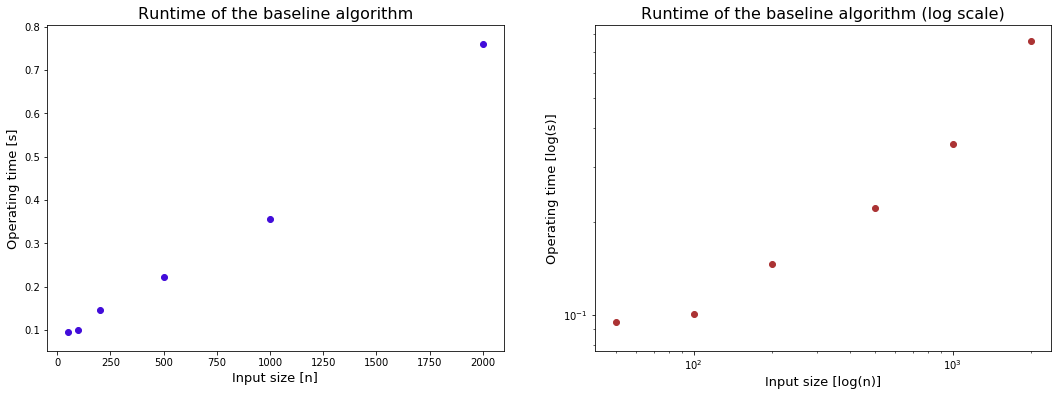

In [16]:
plot_results(limits=limits, runtimes=baseline_runtimes, is_baseline=True)

In [ ]:
plot_results(limits=limits, runtimes=runtimes_cluster_tree, is_baseline=False)

### Assessing the accuracy of predictions:

A simple function to print out some statistics of a model (?)

In [17]:
def timely_statistics(df_tree : pd.DataFrame, relative : bool, statistic : str) -> None:
    '''I automated the prints below ~ Rav
    possibly invoke with:
    for element in [(False, 'mean'), (False, 'median'), (True, 'mean'), (True, 'median')]:
        timely_statistics(df, relative=element[0], statistic=element[1])'''
    
    if(statistic == 'mean' and relative == False):
        seconds1, seconds2 = df_tree['time:absolute_prediction_off'].mean(), df_tree['time:absolute_prediction_correct'].mean()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('absolute off mean: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('absolute correct mean: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'median' and relative == False):
        seconds1, seconds2 = df_tree['time:absolute_prediction_off'].median(), df_tree['time:absolute_prediction_correct'].median()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('absolute off median: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('absolute correct median: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'mean' and relative==True):
        df_tree['time:absolute_prediction_off'].hist(bins=10)
        seconds1, seconds2 = df_tree['time:relative_prediction_off'].mean(), df_tree['time:relative_prediction_correct'].mean()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('relative off mean: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('relative correct mean: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'median' and relative==True):
        df_tree['time:absolute_prediction_off'].hist(bins=10)
        seconds1, seconds2 = df_tree['time:relative_prediction_off'].median(), df_tree['time:relative_prediction_correct'].median()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('relative off median: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('relative correct median: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))

In [18]:
testingBaseline_df_train = pd.read_csv('BPI_2012_train')
testingBaseline_df_train['time:timestamp'] = testingBaseline_df_train['time:timestamp'].apply(fix_time)
testingBaseline_df_train['time:time_between'] = testingBaseline_df_train['time:timestamp'].diff()
testingBaseline_df_train.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

testingBaseline_df_test = pd.read_csv('BPI_2012_test')
testingBaseline_df_test['time:timestamp'] = testingBaseline_df_test['time:timestamp'].apply(fix_time)
testingBaseline_df_test['time:time_between'] = testingBaseline_df_test['time:timestamp'].diff()
testingBaseline_df_test.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

#creates column with predicted data
def prediction(prev):
    return baseline_all_expected_events[0][prev]

testingBaseline_df_test['predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#function that creates the 'correct' using a dataframe, the predcting column and the true column, it shows wether the prediction was correct
testingBaseline_df_test['shifted_actual'] = testingBaseline_df_test['concept:name'].shift(-1)
testingBaseline_df_test['shifted_case_id'] = testingBaseline_df_test['case_id'].shift(-1)
    
def apply_function(var):
    if var[2] == var[3]:
        return (var[0] == var[1])
        
    else:
        return (var[0] == 'editor:close_case')
        
testingBaseline_df_test['correct'] = testingBaseline_df_test[['predicted', 'shifted_actual', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
testingBaseline_df_test = testingBaseline_df_test.drop(['shifted_actual', 'shifted_case_id'], axis=1)

def prediction(prev):
    return baseline_all_expected_events[1][prev]

testingBaseline_df_test['time:between_predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#create column with absolute difference between predicted time and actual time
def time_difference(var):
    return abs((var[0] - var[1]).total_seconds())

def time_difference_if_correct(var):
    if var[0]:
        return abs((var[1] - var[2]).total_seconds())
    else:
        return 0

testingBaseline_df_test['time:absolute_prediction_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:absolute_prediction_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)

#create column with relative difference between predicted time and actual time
def time_difference(var):
    return (var[0] - var[1]).total_seconds()

def time_difference_if_correct(var):
    if var[0]:
        return (var[1] - var[2]).total_seconds()
    else:
        return 0

testingBaseline_df_test['time:relative_prediction_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:relative_prediction_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)


#Changed the code below to this to clean up the notebook. For refernce/troubleshooting, below code is markdowned, not erased
for element in [(False, 'mean'), (False, 'median'), (True, 'mean'), (True, 'median')]:
    timely_statistics(testingBaseline_df_test, relative=element[0], statistic=element[1])

FileNotFoundError: [Errno 2] File b'BPI_2012_train' does not exist: b'BPI_2012_train'

## Triagram method

In [35]:
def apply_triagram(df : pd.DataFrame, lifecycle_name = 'lifecycle:transition P', concept_name = 'concept:name P') -> pd.DataFrame:
    '''creates row lifecycle_name (called 'lifecycle:transition P' by default
    and concept_name (called 'concept:name P' by default, which contains the prediction we know for certain.
    If a value can not be predicted like this it is given the np.nan value'''
    
    df['concept:name S1'] = df['concept:name'].shift(1)
    df['concept:name S2'] = df['concept:name'].shift(2)
    df['lifecycle:transition S1'] = df['lifecycle:transition'].shift(1)
    df['lifecycle:transition S2'] = df['lifecycle:transition'].shift(2)
    df['case_id S1'] = df['case_id'].shift(1)
    df['case_id S2'] = df['case_id'].shift(2)


    first_case = df['step_number'] == 0
    second_case = df['step_number'] == 1

    triagram1 = df['lifecycle:transition S1']+df['lifecycle:transition S2'] == 'COMPLETESCHEDULE'
    triagram2 = df['concept:name S1']+df['concept:name S1'] == 'WW'
    triagram3 = df['concept:name S1'] != df['concept:name S1']
    triagram4 = df['case_id'] == df['case_id S1']
    triagram5 = df['case_id'] == df['case_id S2']

    df['lifecycle:transition P'] = np.nan
    df['concept:name P'] = np.nan

    df.loc[first_case, lifecycle_name] = 'COMPLETE'
    df.loc[second_case, lifecycle_name] = 'COMPLETE'
    df.loc[(triagram1&triagram2&triagram3&triagram4&triagram5), 'concept:name P'] = 'START'

    df.loc[first_case, concept_name] = 'A_SUBMITTED'
    df.loc[second_case, concept_name] = 'A_PARTLYSUBMITTED'
    df.loc[(triagram1&triagram2&triagram3&triagram4&triagram5), 'concept:name P'] = df.loc[(triagram1&triagram2&triagram3&triagram4&triagram5), 'concept:name S2']

    df = df.drop(['concept:name S1', 'concept:name S2', 'lifecycle:transition S1', 'lifecycle:transition S2', 'case_id S1', 'case_id S2'], axis=1)
    df['combined P'] = df['lifecycle:transition P'] + ' + ' + df['concept:name P']
    df['combined P'] = df['combined P'].shift(-1)
    df['combined P'] = df['combined P'].map({'COMPLETE + A_SUBMITTED': 'editor: close_case'})
    return df

In [36]:
def add_W_active(df, column_name = 'W_active'):
    converter = {'STARTW':True, 'COMPLETEW': False}
    df['W_active'] = False
    df['life_concept'] = df['lifecycle:transition'] + df['concept:name'].astype(str).str[0]
    df['life_concept S1'] = df['life_concept'].shift(1)

    df.loc[0, 'W_active'] = False
    df.loc[df['step_number'] ==0, 'W_active'] = False
    df.loc[df['life_concept S1'] == 'STARTW', 'W_active'] = True
    df.loc[df['life_concept S1'] == 'COMPLETEW', 'W_active'] = False
    
    for i in range(0, 50):  
        df['W_active'] = df['W_active'].shift(1)
    
        df.loc[0, 'W_active'] = False
        df.loc[df['step_number'] ==0, 'W_active'] = False
        df.loc[df['life_concept S1'] == 'STARTW', 'W_active'] = True
        df.loc[df['life_concept S1'] == 'COMPLETEW', 'W_active'] = False

    df = df.drop(columns = ['life_concept', 'life_concept S1'])
    return df

In [37]:
df = apply_triagram(df)
df = add_W_active(df)

## Model

In [38]:
def prepare_dataframe_for_clustering(raw_df):
    ''''''
    
    df = raw_df.copy()
    df['combined_names'] = df['lifecycle:transition'] + ' + ' + df['concept:name']
    
    #Prepare the time between columns
    if (type(df['time:timestamp'].iloc[0]) != datetime.datetime):
        df['time:timestamp'] = df['time:timestamp'].apply(fix_time)

    df["time:time_between"] = df["time:timestamp"].diff()
    df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0) #Changed it a bit to always insert 0 into the first row
    df["time:time_between"] = [int(x.total_seconds()) for x in df["time:time_between"]]
    
    #Prepare the next event column
    df["next_event"] = df["combined_names"]
    df.loc[df['step_number'] == 0, 'next_event'] = 'editor: close_case'
    df["next_event"] = df["next_event"].shift(-1)
    df.loc[len(df) - 1, 'next_event'] = 'editor: close_case'
    
    return (df)


def prepare_column_for_clustering(case_id_column, cluster_column, unique_values):
    ''''''
    
    grouped_df = pd.DataFrame({'case_id': case_id_column, 'column': cluster_column})
    
    for val in unique_values:
        grouped_df[val] = 0
        grouped_df.loc[grouped_df['column'] == val, val] = 1
    
    return grouped_df[['case_id'] + list(unique_values)]


def get_clusters(prepared_rows):
    ''''''
    
    kmeans = KMeans(n_clusters=NR_OF_CLUSTERS)
    
    unique_columns = list(prepared_rows.columns)
    unique_columns.pop(0)

    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    kmeans.fit(df_grouped[unique_columns])
    prediction = kmeans.labels_
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))}), kmeans


def get_tree(df, clusters, MAX_DEPTH, N_ESTIMATORS):
    ''''''
    
    model = MultiOutputClassifier(RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH))
    
    X_dtc = df[clusters + ['step_number', 'time:weekday', 'time:hour', 'lifecycle:transition int', 'W_active']]
    y_dtc = df[['next_event int', 'time:time_between']]

    model.fit(X_dtc, y_dtc)
    
    return model


def predict_clusters(cluster_model, prepared_rows, unique_columns):
    ''''''
    
    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    prediction = cluster_model.predict(df_grouped[unique_columns])
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))})


def predict_value(tree, df_predict, clusters):
    ''''''
    
    X_dtc = df_predict[clusters + ['step_number', 'time:weekday', 'time:hour', 'lifecycle:transition int', 'W_active']]
    
    prediction = tree.predict(X_dtc)
    return prediction

In [39]:
def cluster_tree_predict(df_train, df_test):
    ''''''
    
    #I splitted this into 2 lines solely for debugging purposes:
    cluster_tree_train = prepare_dataframe_for_clustering(df_train)
    cluster_tree_test = prepare_dataframe_for_clustering(df_test)
    
    cluster_tree_train = add_W_active(cluster_tree_train)
    cluster_tree_test = add_W_active(cluster_tree_test)
    
    le = pre.LabelEncoder()
    le.fit(cluster_tree_train['lifecycle:transition'].unique())
    cluster_tree_train['lifecycle:transition int'] = le.transform(cluster_tree_train['lifecycle:transition'])
    cluster_tree_test['lifecycle:transition int'] = le.transform(cluster_tree_test['lifecycle:transition'])
    
    le2 = pre.LabelEncoder()
    unique_ones = np.concatenate((cluster_tree_train['next_event'].unique(), cluster_tree_test['next_event'].unique()))
    le2.fit(unique_ones)
    cluster_tree_train['next_event int'] = le2.transform(cluster_tree_train['next_event'])
    cluster_tree_test['next_event int'] = le2.transform(cluster_tree_test['next_event'])
    
    #Clustering
    cluster_columns = ['combined_names'] # ENTER CLUSTER COLUMN NAMES (max 2) HERE
    assigned_columns = [cluster_columns[i] + ' cluster' for i in range(len(cluster_columns))]
    
    for i in range(len(cluster_columns)):
        #Make sure no NaN values exist in these columns
        cluster_tree_train[cluster_columns[i]] = cluster_tree_train[cluster_columns[i]].fillna(-1)
        cluster_tree_test[cluster_columns[i]] = cluster_tree_test[cluster_columns[i]].fillna(-1)
        
        unique_values = list(cluster_tree_train[cluster_columns[i]].unique())
        unique_values_test = cluster_tree_test[cluster_columns[i]].unique()
        
        unique_values.extend(x for x in unique_values_test if x not in unique_values)
        
        prepared_train_data = prepare_column_for_clustering(cluster_tree_train['case_id'], cluster_tree_train[cluster_columns[i]], unique_values)
        cluster_tree_train[assigned_columns[i]], cluster_model = get_clusters(prepared_train_data)

        prepared_test_data = prepare_column_for_clustering(cluster_tree_test['case_id'], cluster_tree_test[cluster_columns[i]], unique_values)
        cluster_tree_test[assigned_columns[i]] = predict_clusters(cluster_model, prepared_test_data, unique_values)
    
    first_steps_train = cluster_tree_train['step_number'] <= CLUSTER_STEP_SPLIT
    first_steps_test = cluster_tree_test['step_number'] <= CLUSTER_STEP_SPLIT
    
    model = get_tree(cluster_tree_train[first_steps_train], ['next_event int'], BEGIN_TREE_DEPTH, N_ESTIMATORS)
    result = predict_value(model, cluster_tree_test[first_steps_test], ['next_event int'])
    cluster_tree_test.loc[first_steps_test, 'prediction'] = le2.inverse_transform(result[:, 0])
    cluster_tree_test.loc[first_steps_test, 'time:between_predicted'] = result[:, 1]
    
    for i in tqdm(range(NR_OF_CLUSTERS)):
        next_amount = NR_OF_CLUSTERS
        if len(cluster_columns) == 1:
            next_amount = 1
        for j in range(next_amount):
            first_cluster_train = (cluster_tree_train[assigned_columns[0]] == i)
            first_cluster_test = (cluster_tree_test[assigned_columns[0]] == i) & (cluster_tree_test['step_number'] > CLUSTER_STEP_SPLIT)
            
            if len(cluster_columns) == 1:
                clustered_train_df = cluster_tree_train[first_cluster_train]
                clustered_test_df = cluster_tree_test[first_cluster_test]
            else:
                clustered_train_df = cluster_tree_train[first_cluster_train & (cluster_tree_test[assigned_columns[1]] == j)]
                clustered_test_df = cluster_tree_test[first_cluster_test & (cluster_tree_test[assigned_columns[1]] == j)]
        
            if clustered_train_df.size > 0:
                model = get_tree(clustered_train_df, assigned_columns, CLUSTER_TREE_DEPTH, N_ESTIMATORS)
        
                if clustered_test_df.size > 0:
                    if len(cluster_columns) == 1:
                        result = predict_value(model, clustered_test_df, assigned_columns)
                        cluster_tree_test.loc[first_cluster_test, 'prediction'] = le2.inverse_transform(result[:, 0])
                        cluster_tree_test.loc[first_cluster_test, 'time:between_predicted'] = result[:, 1]
                    else:
                        result = predict_value(model, clustered_test_df, assigned_columns)
                        cluster_tree_test.loc[first_cluster_test & (cluster_tree_test[assigned_columns[1]] == j), 'prediction'] = le2.inverse_transform(result[:, 0])
                        cluster_tree_test.loc[first_cluster_test & (cluster_tree_test[assigned_columns[1]] == j), 'time:between_predicted'] = result[:, 1]
    
    cluster_tree_test = apply_triagram(cluster_tree_test)
    cluster_tree_test.loc[cluster_tree_test['combined P'].isnull(),'combined P'] = cluster_tree_test['prediction']
    cluster_tree_test['prediction'] = cluster_tree_test['combined P']
    cluster_tree_test = cluster_tree_test.drop(['combined P', 'lifecycle:transition int', 'next_event int', 'combined_names cluster', 'lifecycle:transition P', 'concept:name P'], axis=1)
        
    return cluster_tree_test

### Model testing using test data

In [40]:
NR_OF_CLUSTERS = 14
CLUSTER_STEP_SPLIT, BEGIN_TREE_DEPTH, CLUSTER_TREE_DEPTH, N_ESTIMATORS = 7, 7, 12, 75

# 7, 7, 12, 75 = 69.4%
# 9, 5, 12, 75 = 69.1%
# 6, 6, 10, 75 = 68.3
# 6, 6, 8, 100 = 67.5%
# 5, 5, 10, 100 = 67.3%
# 7, 7, 15, 50 = 66.2%
# 4, 4, 10, 125 = 66.2
# 6, 4, 10, 100 = 66.0%
# 5, 5, 7, 125 = 65.5%
# 5, 3, 10, 125 = 64.5%
# 5, 3, 7, 125 = 63.6%

In [41]:
def run_cluster_alg():    
    tracemalloc.start()
    df_tree_cluster = cluster_tree_predict(df_train, df_test) #Will only take one short loading slider to load
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
    tracemalloc.stop()
    cpu = psutil.cpu_percent()
    print('Current CPU usage is {} %'.format(psutil.cpu_percent()))
    return df_tree_cluster

In [42]:
#I used tree as a standin for the df_test result, this can be changed later
df_tree = run_cluster_alg()
df_tree

100%|██████████| 14/14 [01:13<00:00,  4.93s/it]
Current memory usage is 9.500255MB; Peak was 1059.483841MB
Current CPU usage is 0.0 %


,Unnamed: 0,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:weekday,time:hour,time:day,time:event_count,time:busy_day,combined_names,time:time_between,next_event,W_active,prediction,time:between_predicted
0,0,10927,0,112.0,COMPLETE,A_SUBMITTED,2012-02-09 10:44:06.663000+01:00,3,10,9-2-2012,2601,True,COMPLETE + A_SUBMITTED,0,COMPLETE + A_PARTLYSUBMITTED,False,COMPLETE + A_PARTLYSUBMITTED,0.0
1,1,10927,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2012-02-09 10:44:06.956000+01:00,3,10,9-2-2012,2601,True,COMPLETE + A_PARTLYSUBMITTED,0,COMPLETE + A_PREACCEPTED,False,COMPLETE + A_PREACCEPTED,0.0
2,2,10927,2,112.0,COMPLETE,A_PREACCEPTED,2012-02-09 10:44:37.828000+01:00,3,10,9-2-2012,2601,True,COMPLETE + A_PREACCEPTED,30,SCHEDULE + W_Completeren aanvraag,False,SCHEDULE + W_Completeren aanvraag,37.0
3,3,10927,3,112.0,SCHEDULE,W_Completeren aanvraag,2012-02-09 10:44:38.142000+01:00,3,10,9-2-2012,2601,True,SCHEDULE + W_Completeren aanvraag,0,START + W_Completeren aanvraag,False,START + W_Completeren aanvraag,0.0
4,4,10927,4,11019.0,START,W_Completeren aanvraag,2012-02-09 15:00:26.434000+01:00,3,15,9-2-2012,2601,True,START + W_Completeren aanvraag,15348,COMPLETE + W_Completeren aanvraag,False,COMPLETE + W_Completeren aanvraag,7.0
5,5,10927,5,11019.0,COMPLETE,W_Completeren aanvraag,2012-02-09 15:04:07.481000+01:00,3,15,9-2-2012,2601,True,COMPLETE + W_Completeren aanvraag,221,START + W_Completeren aanvraag,True,START + W_Completeren aanvraag,1.0
6,6,10927,6,10933.0,START,W_Completeren aanvraag,2012-02-09 18:33:41.637000+01:00,3,18,9-2-2012,2601,True,START + W_Completeren aanvraag,12574,COMPLETE + W_Completeren aanvraag,False,COMPLETE + W_Completeren aanvraag,0.0
7,7,10927,7,10933.0,COMPLETE,W_Completeren aanvraag,2012-02-09 18:35:02.408000+01:00,3,18,9-2-2012,2601,True,COMPLETE + W_Completeren aanvraag,80,START + W_Completeren aanvraag,True,START + W_Completeren aanvraag,1.0
8,8,10927,8,11179.0,START,W_Completeren aanvraag,2012-02-10 09:23:01.731000+01:00,4,9,10-2-2012,2231,False,START + W_Completeren aanvraag,53279,COMPLETE + W_Completeren aanvraag,False,COMPLETE + W_Completeren aanvraag,43967.0
9,9,10927,9,11179.0,COMPLETE,W_Completeren aanvraag,2012-02-10 09:24:52.967000+01:00,4,9,10-2-2012,2231,False,COMPLETE + W_Completeren aanvraag,111,START + W_Completeren aanvraag,True,START + W_Completeren aanvraag,158.0


In [43]:
#prints accuracy of the tree dataset
accuracy = round((len(df_tree[df_tree['next_event'] == df_tree['prediction']])/len(df_tree))*100, 1)
print('accuracy: ' + str(accuracy) + '%')

accuracy: 69.2%


In [44]:
#shows which predictions are given too much (>1) and which too little (<1)
predicted_correct_events = Counter(list(df_tree[df_tree['next_event'] == df_tree['prediction']]['prediction']))
predicted_events = Counter(list(df_tree['prediction']))
true_events = Counter(list(df_tree['next_event']))

for i in predicted_events:
    if i != i:
        break
    print(i)
    per = round(predicted_events[i]/true_events[i]*100, 1)
    print(str(per) + '%')
    print('importance: ' + str(abs(predicted_events[i] - true_events[i])))
    if per > 100:
        print('given ' + str(round(per-100, 1)) + '% too much')
    
    elif per < 100:
        print('given ' + str(round(100-per, 1)) + '% too little')
    
    else:
        print('given exactly the right amount')
   
    print('')

COMPLETE + A_PARTLYSUBMITTED
100.0%
importance: 0
given exactly the right amount

COMPLETE + A_PREACCEPTED
99.7%
importance: 4
given 0.3% too little

SCHEDULE + W_Completeren aanvraag
102.1%
importance: 26
given 2.1% too much

START + W_Completeren aanvraag
104.3%
importance: 177
given 4.3% too much

COMPLETE + W_Completeren aanvraag
96.2%
importance: 157
given 3.8% too little

editor: close_case
149.1%
importance: 1060
given 49.1% too much

COMPLETE + A_FINALIZED
49.9%
importance: 404
given 50.1% too little

COMPLETE + W_Nabellen offertes
109.3%
importance: 246
given 9.3% too much

SCHEDULE + W_Nabellen offertes
71.4%
importance: 294
given 28.6% too little

START + W_Nabellen offertes
163.4%
importance: 1669
given 63.4% too much

COMPLETE + O_SENT_BACK
125.7%
importance: 133
given 25.7% too much

START + W_Nabellen incomplete dossiers
154.1%
importance: 783
given 54.1% too much

START + W_Valideren aanvraag
125.1%
importance: 282
given 25.1% too much

SCHEDULE + W_Nabellen incomplete 

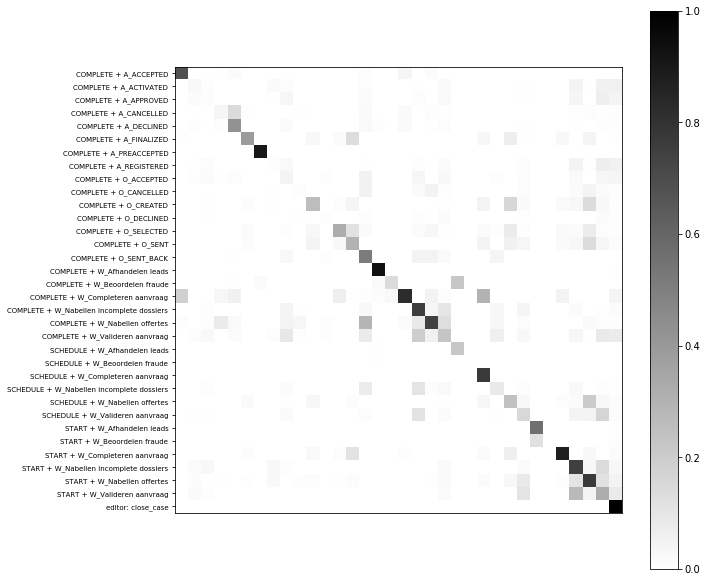

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
step_nr_start, step_nr_end = 5, 500
df_to_check = df_tree[(df_tree['step_number'] >= step_nr_start) & (df_tree['step_number'] <= step_nr_end)]
df_confusion = pd.crosstab(df_to_check['next_event'], df_to_check['prediction'], rownames=['next_event'], colnames=['prediction'])
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    fig = plt.figure(figsize=(10,10))
    plt.matshow(df_confusion, cmap=cmap, fignum=1)
    dd = list(df_confusion.columns)
    plt.xticks([])
    plt.yticks(range(0,len(dd)), dd)
    plt.yticks(fontsize=7)
    #plt.title(title)
    plt.colorbar()
    plt.savefig('confusion_matrix.png',  bbox_inches='tight')
    tick_marks = np.arange(len(df_confusion.columns))
    #plt.tight_layout()
    #plt.ylabel(df_confusion.index.name)
    #plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)
df_conf_norm.to_csv('normalized.csv')
df_confusion.to_csv('confusion.csv')

relative off mean: 3163.1090141866002, 52.71848356977667, 0.8786413928296112, 0.036610058034567135
relative correct mean: 3163.1090141866002, 52.71848356977667, 0.8786413928296112, 0.036610058034567135
relative off median: 1.0, 0.016666666666666666, 0.0002777777777777778, 1.1574074074074073e-05
relative correct median: 1.0, 0.016666666666666666, 0.0002777777777777778, 1.1574074074074073e-05
absolute off mean: 37446.21976286631, 624.1036627144385, 10.40172771190731, 0.4334053213294712
absolute correct mean: 37446.21976286631, 624.1036627144385, 10.40172771190731, 0.4334053213294712
absolute off median: 31.0, 0.5166666666666667, 0.008611111111111111, 0.0003587962962962963
absolute correct median: 31.0, 0.5166666666666667, 0.008611111111111111, 0.0003587962962962963


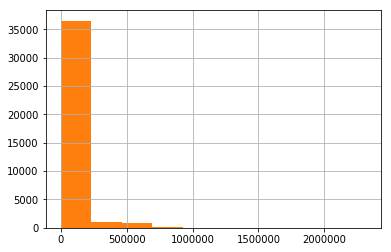

In [46]:
#shows time related attributes of tree (assuming that time is stored in 'time:between_predicted')
#create column with absolute difference between predicted time and actual time
def time_difference_if_correct(var):
    if var[0]:
        return abs((var[1] - var[2]))
    else:
        return (0)
    
def apply_function(var):
    if var[2] == var[3]:
        return (var[0] == var[1])
        
    else:
        return (var[0] == 'editor:close_case')
        
df_tree['shifted_case_id'] = df_tree['case_id'].shift(-1)
df_tree.loc[len(df_tree) - 1, 'shifted_case_id'] = 0
df_tree['correct'] = df_tree[['prediction', 'next_event', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
df_tree = df_tree.drop(['shifted_case_id'], axis=1)

df_tree['time:relative_prediction_off'] = df_tree['time:time_between'] - df_tree['time:between_predicted']
df_tree['time:absolute_prediction_off'] = df_tree['time:relative_prediction_off'].abs()

df_tree['time:relative_prediction_correct'] = df_tree['time:time_between'] - df_tree['time:between_predicted']
df_tree['time:absolute_prediction_correct'] = df_tree['time:relative_prediction_correct'].abs()    
        
for element in [(True, 'mean'), (True, 'median'), (False, 'mean'), (False, 'median')]:
    timely_statistics(df_tree, relative=element[0], statistic=element[1])

# Markov

In [47]:
def createChain(df):
    df_chain = df.copy()
    chain = {}
    shape = df_chain.shape[0]
    conceptNames = ['editor: first event'] + list(df_chain['concept:name'])
    ids = ['editor: first id'] + list(df_chain['case_id']) #Otherwise we check i+1-th position that does not exist


    for i, key1 in enumerate(conceptNames):

        if shape > i + 2:
            key2 = conceptNames[i+1]
            event = conceptNames[i+2]


            if (ids[i] == ids[i+2]): 

                if ((key1, key2) not in chain):
                    chain[(key1, key2)] = [event] 
                else:
                    chain[(key1, key2)].append(event)

            elif (event == 'A_SUBMITTED'): 

                if ((key1, key2) not in chain):
                    chain[(key1, key2)] = ['editor: close_case']
                else:
                    chain[(key1, key2)].append('editor: close_case')

            elif (key2 == 'A_SUBMITTED'):

                if ((key1, key2) not in chain):
                    chain[(key1, key2)] = ['A_PARTLYSUBMITTED']
                else:
                    chain[(key1, key2)].append('A_PARTLYSUBMITTED')
    
    print('Chain size: {0} distinct event pairs.'.format(len(chain)))
    
    return chain

def getPredictions(df, chain):
    df_2markov = df.copy()
    nextEvents = []

    for i in tqdm(range(-1, df_2markov.shape[0] - 1)):

        if (i == -1):
            event1 = 'editor: first event'
        else:
            event1 = df_2markov['concept:name'][i]

        event2 = df_2markov['concept:name'][i+1]
        
        if ((event1, event2) in chain):
            nextEvents.append(random.choice(chain[(event1, event2)]))
        else:
            nextEvents.append(event2) #only for the code to work
        
        
        
    return nextEvents

In [48]:
def run_markov_alg():    
    tracemalloc.start()

    df_2validation = df_validation.copy()

    chain = createChain(df_train)

    eventPredictions = getPredictions(df_2validation, chain)

    df_2validation['Prediction'] = eventPredictions

    #Prepare the next event column
    df_2validation['next_event'] = df_2validation['concept:name']
    df_2validation.loc[df_2validation['step_number'] == 0, 'next_event'] = 'editor: close_case'
    df_2validation['next_event'] = df_2validation['next_event'].shift(-1)
    df_2validation.loc[len(df) - 1, 'next_event'] = 'editor: close_case'
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
    tracemalloc.stop()
    cpu = psutil.cpu_percent()
    print('Current CPU usage is {} %'.format(psutil.cpu_percent()))

    return df_2validation


In [49]:
df_2validation = run_markov_alg()

Chain size: 134 distinct event pairs.
100%|██████████| 96902/96902 [00:03<00:00, 30466.64it/s]
Current memory usage is 14.930679MB; Peak was 25.885675MB
Current CPU usage is 0.0 %


In [50]:
accuracy = round((len(df_2validation[df_2validation['next_event'] == df_2validation['Prediction']])/len(df_2validation))*100, 1)
print('accuracy: ' + str(accuracy) + '%')

accuracy: 73.3%


### Visualizations

In [ ]:
from sklearn.decomposition import PCA
from random import randint
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
#Group pre-cluster df by case (case_id)
precluster_df = prepare_column_for_clustering(df['case_id'], df['concept:name'], df['concept:name'].unique())
precluster_df_by_case = precluster_df.groupby('case_id').sum()
precluster_df_by_case.head()

In [ ]:
#Perform PCA (2 component) on the data
pca2d = PCA(n_components = 2)
pca2d.fit(precluster_df_by_case)

In [ ]:
#Perform PCA (3 component) on the data
pca3d = PCA(n_components = 3)
pca3d.fit(precluster_df_by_case)

In [ ]:
#Create 2d dataframe
pca2d_df = pd.DataFrame(pca2d.transform(precluster_df_by_case))
pca2d_df.index.names = ['case_id']
pca2d_df.head()

In [ ]:
#Create 3d dataframe
pca3d_df = pd.DataFrame(pca3d.transform(precluster_df_by_case))
pca3d_df.index.names = ['case_id']
pca3d_df.head()

In [ ]:
#Retrieve Clusters
df['concept:name cluster'], cluster_model = get_clusters(precluster_df)

In [ ]:
#Group regular df by case (case_id)
df_by_case = df.groupby('case_id').mean()[['concept:name cluster']]
df_by_case.head()

In [ ]:
#Merge the dataframes for 2d
vis2d_df = pd.merge(df_by_case, pca2d_df, on='case_id', how='left')
vis2d_df.columns = ['cluster', 'x_comp', 'y_comp']
vis2d_df.head()

In [ ]:
#Merge the dataframes for 3d
vis3d_df = pd.merge(df_by_case, pca3d_df, on='case_id', how='left')
vis3d_df.columns = ['cluster', 'x_comp', 'y_comp', 'z_comp']
vis3d_df.head()

In [ ]:
#Plot with low alpha
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.25});

In [ ]:
#Plot with high alpha
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.9});

In [ ]:
def random_colorscale(n):
    lst = []
    scale = 0
    initial = ['red','green','blue','orange','yellow','purple','black','pink','cyan','magenta']
    for i in range(n):
        if i < len(initial):
            color = initial[i]
        else:
            color = "#" + "%06x" % randint(0, 0xFFFFFF)
        lst.append((round(scale, 2), color))
        scale += 1/(n-1)
        
    
    return lst
#[(0, "red"), (0.14, "yellow"), (0.29, "purple"), (0.43, "green"), (0.57, "blue"), (0.71, "black"), (0.86, "orange"), (1, "pink")]
random_colorscale(4)
random_colorscale(NR_OF_CLUSTERS)

In [ ]:
lst = [(0, "red"), (0.14, "yellow"), (0.29, "purple"), (0.43, "green"), (0.57, "blue"), (0.71, "black"), (0.86, "orange"), (1, "pink")]
fig = go.Figure(data=[go.Scatter3d(
    x=vis3d_df['x_comp'],
    y=vis3d_df['y_comp'],
    z=vis3d_df['z_comp'],
    mode='markers',
    marker=dict(
        size=4,
        color=vis3d_df['cluster'],
        colorscale=random_colorscale(14),
        opacity=0.5
    )
)])
fig.show()

# Functions (g)raveyard:

If you can get rid of something, but are afraid this might actually turn out useful in future:

def iterating_expected_actions(df : pd.DataFrame, concept_name : str, n : int) -> list:
    '''concept_name is the starting point (first action)
    n is the length of the longest trace ever observed
    It is stored in lonest_trace but for runtime reasons, use n so far
    '''
    
    longest_trace = max(df['step_number']) #finding the longest trace in the database (nr of steps)
    #note that we determine this AFTER deleting some rows with uncomplete steps. We should be running this on full df
    
    i = 0
    actions = [concept_name] #Here is the list that will store all the subsequent actions the algorithm decices to perform
    while (i < n): #terminate if we are exceeding the max number of steps
        wow = creating_dict_for_next_step_stats(df, concept_name)[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        
        if(cycles_shortcut(actions, concept_name, n) != False): #Checks if we are stuck in a loop
            print("we are stuck in a loop")
            return(cycles_shortcut(actions, concept_name, n))
        
        if(concept_name == 'editor: close_case'): #If it is the "terminate" option - terminate
            break
        actions.append(concept_name) #Add the action to the list
        i += 1
    
    actions.append('editor: close_case')
    #print('i = ', i, "n = ", n)
    
    return(actions)